# Phases of the Ising Model with Logistic Regression

This notebook is modified from notebooks originally developed in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html).


#### Preamble

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


## Learning Goal
The goal of this notebook is to show how one can employ Logistic Regression to classify the states of the 2D Ising model according to their phase. We will discuss overfitting, regularization, and learn how to use the scikit-learn library. We will also examine the role of the optimizer in making predictions.

Recall that the energy function of the classical Ising model is given by the Hamiltonian

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. In two dimensions, Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.



# Perform an experiment and record observations

+ For the Ising model, we saw that linear regression was the best choice of machine learning methods, because it effectively finds the coupling matrix $J$ for a Hamiltonian
+ Most of the time, our machine learning model only approximates the generator, which usually has a functional form that defies an exact representation using the ML model
+ Here, we will again use the Ising model as our experiment. However, instead of regressing energies based on microstates, we instead will ask a bigger question: can we predict the phase of the system based on only the microstate? 
+ If we can successfully perform this operation, then we've essentially learned a computational surrogate for our experiments, which might be expensive to perform individually. The surrogates could be used to find critical points, for example.

## The Ising model

Given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for logistic regression. Notice that, for the purposes of applying logistic regression, the 2D spin state of the Ising model will be flattened out to a 1D array, so it will not be easy to learn information about the structure of the contiguous ordered 2D domains [see figure below]. Such information can be incorporated using other methods such as multi-layer deep convolutional neural networks (CNNs), see Secs. IX, X and XI of the review and the corresponding notebooks.

## The 2D Ising Dataset

+ We consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. 
+ Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.
+ It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5$) and disordered ($T/J>2.5$).
+ We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

# Load the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [16]:
import pickle, os
from urllib.request import urlopen

from sklearn.model_selection import train_test_split

class IsingSimulation:
    """
    A container class for the Ising model simulation data.
    """

    def __init__(self):
        self.load_simulation()

    def load_simulation(self):
        """
        Load the compressed data and format it into a configuration amenable to 
        machine learning.
        """
        ## URL of data
        url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
        # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
        data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
        # The labels are obtained from the following file:
        label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

        # Ising model parameters used in the simulation
        self.L = 40  # linear system size
        self.J = -1.0  # Ising interaction
        self.T = np.linspace(0.25, 4.0, 16)  # set of temperatures
        self.T_c = 2.26  # Onsager critical temperature in the TD limit

        # Load dataset into numpy
        X_all = pickle.load(
            urlopen(url_main + data_file_name)
        )  # pickle reads the file and returns the Python object (1D array, compressed bits)
        X_all = np.unpackbits(X_all).reshape(
            -1, 1600
        )  # Decompress array and reshape for convenience
        X_all = X_all.astype("int")
        X_all[
            np.where(X_all == 0)
        ] = -1  # map 0 state to -1 (Ising variable can take values +/-1)
        self.X_all = X_all

        # LABELS (convention is 1 for ordered states and 0 for disordered states)
        labels = pickle.load(
            urlopen(url_main + label_file_name)
        )
        self.labels = labels
        ##  pickle reads the file and returns the Python object (here just a 1D array with
        ##  binary labels)
        self.num_classes = np.unique(self.labels) # should be 2: ordered or disordered

        
    def reshape_datapoint(self, x):
        """
        Given a single simulation snapshot, reshape into original square lattice
        """
        return x.reshape(self.L, self.L)
        
    def find_magnetization(x, axis=-1):
        """
        Given a single simulation snapshot, calculate the magnetization
        """
        return np.mean(x, axis=axis)

    def split_data(self, split_ratio=0.5):
        """
        Split data into training and test sets
        
        Parameters:
        split_ratio (float): ratio of training data to total data
        """

        # pick random data points from ordered and disordered states
        # to create the training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_all, self.labels, train_size=split_ratio, test_size=1.0 - split_ratio
        )

        return X_train, X_test, y_train, y_test

    

dataset = IsingSimulation()

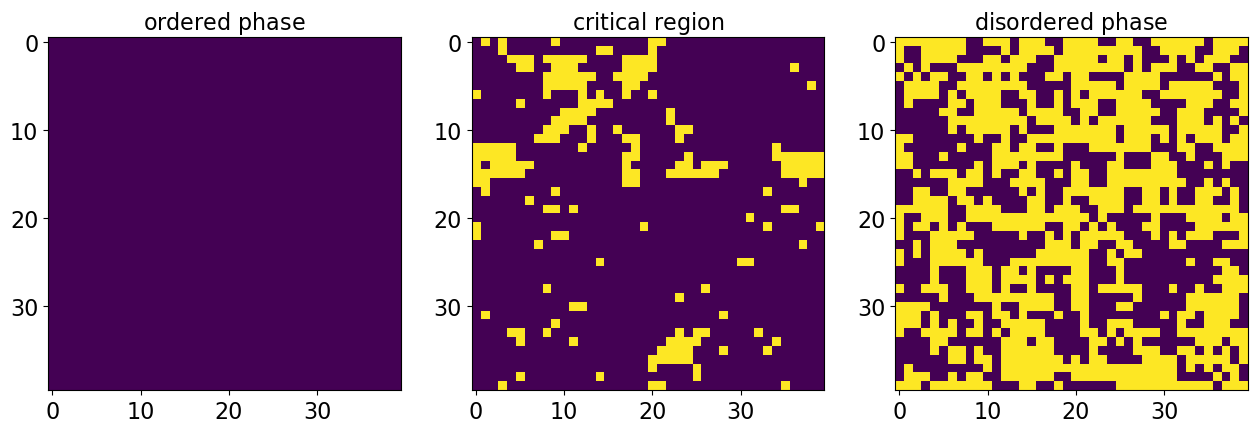

In [35]:
##### plot a few representative Ising states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(dataset.reshape_datapoint(dataset.X_all[20001]))
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(dataset.reshape_datapoint(dataset.X_all[80001]))
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(dataset.reshape_datapoint(dataset.X_all[150001]))
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()


## Logistic regression

+ Earlier, we used linear regression to fit the energy of the Ising model given observations of the spin configuration
+ Energy is a continuous variable, that changes relatively smoothly in response to small changes in microstates (such as individual spin flips)
+ Phase is a different label, more akin to *classification* and not *regression*.

**Idea: perform a linear regression, and then assign a label by applying a nonlinear function to the linear output**

Logistic regression:
$$
\hat y_i = \dfrac{1}{1 + \exp(- A \cdot X_i)}
$$
Where $A$ is a learnable parameter vector that defines the relative weight of the different observed features in our dataset. Our goal will be for $hat y_i$ to match the true label (phase), $y_i$. However, because the logistic function is sigmoidal, $y_i$ will be $\pm 1$ for most values of $X$.

Can relate this to  linear regression problem through the use of a "link function" $g(.)$
$$
A \cdot X_i = g(y_i) \equiv \log(y_i/(1 - y_i))
$$



## How do we fit our model?

+ A seemingly obvious choice: transform our labels/regression targets with the link function $g$ and then fit a linear regression using standard methods
+ + So far with have fit linear models with matrix inversion and iterative approaches, but [other methods exist](https://scikit-learn-extra.readthedocs.io/en/stable/auto_examples/plot_robust_regression_toy.html)


+ Issues with performing ordinary least squares on transformed data:
+ + Linear regression with OLS (ie, matrix methods) assumes errors are normally distributed. Without any additional information, we might assume that the measurements ($X_i$) have normally-distributed errors, but that doesn't mean that $g(X_i)$ has normal errors
+ + In practice, this causes certain errors to be overweighted based on the 
+ + Can look at the residuals between predictions and true on training data; we want "uniform scatter" that we can attribute to uncertainty rather than systematic modelling error


+ Better options: Fit untransformed data directly via maximum likelihood fitting, via iterative methods like gradient descent, Newton–Raphson, quasi-Newton



### Other link functions exist for different data types

+ Count data: logarithmic transform
+ Power law data: double logarithm
+ Poisson and Binomial: rate depends on linear transform

This class of models is sometimes called [General Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model)

In [101]:
## Fit logistic regression model
from sklearn import linear_model

## pick random data points from ordered and disordered states
X_train, X_test, y_train, y_test = dataset.split_data()

model_logistic = linear_model.LogisticRegression()

model_logistic.fit(X_train, y_train)

y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)



print("Classification accuracy on training set: ", np.sum(y_pred_train == y_train) / len(y_train))
print("Classification accuracy on test set: ", np.sum(y_pred_test == y_test) / len(y_test))

Classification accuracy on training set:  0.6948375
Classification accuracy on test set:  0.6633


Not all datapoints are created equal. We can compute the magnetization order parameter for each microstate, which corresponds to the mean bearing of all spins. 

Text(0, 0.5, 'Classification accuracy')

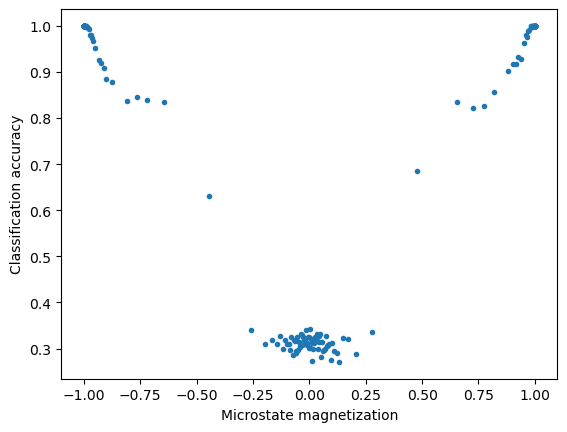

In [138]:


X_all = dataset.X_all.copy()
y_all = dataset.labels.copy()


## Compute magnetization and sort datapoints by magnetization
magnetization = np.mean(X_all, axis=1)
sort_inds = np.argsort(magnetization)
magnetization = magnetization[sort_inds]
X_all = X_all[sort_inds, :]
y_all = y_all[sort_inds]

## Bin the datapoints by magnetization and compute the classifier accuracy
## in each magntization bin
bin_width = 1000
all_acc = []
all_mag = []
for i in range(0, len(X_all) - bin_width, bin_width):
    X_batch, y_batch = X_all[i:i+bin_width], y_all[i:i+bin_width]

    y_pred = model_logistic.predict(X_batch)
    acc = np.sum(y_pred == y_batch) / len(y_batch)
    all_acc.append(acc)

    mag = np.mean(magnetization[i:i+bin_width])
    all_mag.append(mag)


plt.plot(all_mag, all_acc, '.')
plt.xlabel('Microstate magnetization')
plt.ylabel('Classification accuracy')

### Interpreting the results

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 

## Error scoring for classification

+ The mean squared error could work, but for labelling problems where predictions take discrete values, other error functions may be preferable

+ An intuitive metric would be the accuracy: $$Acc = \dfrac{1}{N} \sum_i^{N} \mathcal{I}_{y_i, \hat{y}_i}$$ where $\mathcal{I}$ denotes the indicator function, which returns $1$ if the prediction $\hat{y}_i$ equals the true label $y_i$, and zero otherwise. The accuracy is the fraction of microstates that were assigned the correct phase.

+ For other classification problems or categorical problems, we might use the cross-entropy loss. This has the benefit of being differentiable, and some methods of training logistic regression models use this as an objective function to optimize. $$\mathcal{L}(y, \hat{y}) =\ -y\log {\hat {y}}-(1-y)\log(1-{\hat {y}})$$ Notice that this function is zero when $\hat{y} = y_i$ and one when $\hat{y} = 1 - y_i$, but it also takes intermediate values in the "transition" region of the logistic function. 
+ + With some algebra, you can actually derive the cross-entropy loss from the logistic regression function, or from the definition of entropy for discrete sets


+ Many other metrics exist for classification problems. For example, when classes are extremely imbalanced (ie, we only have a few observations of one phase, but many of another), the accuracy gives a deceptive picture of our method's accuracy. Other metrics to consider include the balanced accuracy, as well as the true positive rate, false positive rate, and confusion matrix

In [57]:
def cross_entropy(y, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # clip to avoid log(0)
    return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def accuracy(y, y_pred):
    return np.sum(y == y_pred) / len(y)

print("Accuracy on training set: ", accuracy(y_train, model_logistic.predict(X_train)))
print("Cross-entropy on training set: ", cross_entropy(y_train, model_logistic.predict_proba(X_train)[:, 1]), "\n")

print("Accuracy on test set: ", accuracy(y_test, y_pred_test))
print("Cross-entropy on test set: ", cross_entropy(y_test, y_pred_test))

Accuracy on training set:  0.6921375
Cross-entropy on training set:  53809.76985427885 

Accuracy on test set:  0.66255
Cross-entropy on test set:  932429.2788504167


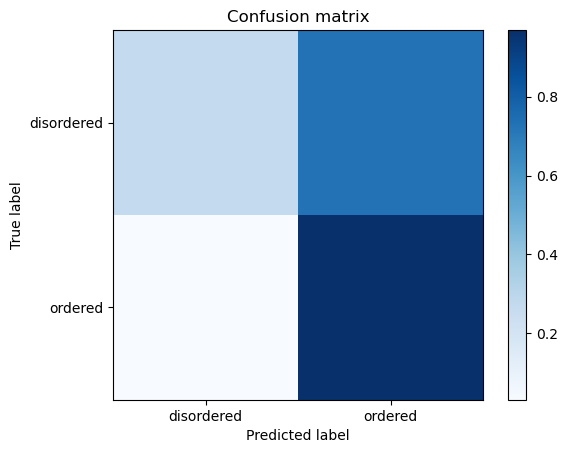

In [63]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test, normalize="true")

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["disordered", "ordered"])
plt.yticks(tick_marks, ["disordered", "ordered"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

## Accuracy is a deceptive metric

+ COVID in 2020 claimed 98% accuracy predicing whether a patient had COVID or not based on CT scans of lung tissue
+ + This was a result of the fact that the dataset was imbalanced: 98% of the patients did not have COVID




+ Several quantities to know for binary classification problems:
+ + True positive rate (TPR): $\dfrac{TP}{TP + FN}$
+ + False positive rate (FPR): $\dfrac{FP}{FP + TN}$
+ + True negative rate (TNR): $\dfrac{TN}{TN + FP}$
+ + False negative rate (FNR): $\dfrac{FN}{FN + TP}$

+ + These are also known as the sensitivity, specificity, and precision, respectively

#### The confusion matrix visualizes these quantities pictorally

+ + Precision is the fraction of positive predictions that are correct: $\dfrac{TP}{TP + FP}$
+ + Recall is the fraction of positive samples that are correctly predicted: $\dfrac{TP}{TP + FN}$






+ Composite scores account for imbalance in training data
+ + Balanced accuracy: $\dfrac{1}{2} \left( \dfrac{TP}{TP + FN} + \dfrac{TN}{TN + FP} \right)$

+ + F1 score: $\dfrac{2}{\dfrac{1}{TPR} + \dfrac{1}{precision}}$

## Bootstrapping

+ What if we want to assign error ranges to our predictions? 
+ Many parametric models have well-defined error properties. For example, if we fit a Gaussian to a point cloud, we can read off the uncertainty of the centroi because the variance is actually a fitting parameter
+ We have explicit equations describing linear and logistic regression; we can imagine propagating uncertainties in the inputs directly through the model
+ For a black-box or very complex model where we only have the ability to compute input/output pairs, we need to do something more creative.
+ Bootstrapping: randomly subsample the input data *with replacement*, and generate new predictions. 
+ + Why replacement? For finite datasets, we treat the dataset as an empirical approximation of the data population itself. We therefore want to approximate sampling the original population, while reducing dependence on the specificities of our original distribution. For example, resampling helps us avoid outliers.
+ + Compared to full error propagation, bootstrapping is usually computationally expensive but conceptually simple. Extremely useful for non-differentiable models, small training datasts, or unusual feature distributions

In [71]:
def bootstrap(model, X, y, n=100, verbose=False):
    """Bootstrap the data and fit the model n times.
    
    Args:
        model (sklearn model): model to fit
        X (np.array): dataset to fit
        y (np.array): labels to fit
        n (int): number of bootstraps
        verbose (bool): print progress

    Returns:
        accs (np.array): array of accuracies
        cens (np.array): array of cross-entropies
    """
    accs, cens = np.zeros(n), np.zeros(n)
    for i in range(n):
        if verbose and i % (n // 10) == 0:
            print(f"Bootstrap {i}/{n}", flush=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        accs[i] = accuracy(y_test, y_pred_test)
        cens[i] = cross_entropy(y_test, y_pred_test)
    return accs, cens

accs, cens = bootstrap(model_logistic, dataset.X_all, dataset.labels, verbose=True)

Bootstrap 0/100
Bootstrap 10/100
Bootstrap 20/100
Bootstrap 30/100
Bootstrap 40/100
Bootstrap 50/100
Bootstrap 60/100
Bootstrap 70/100
Bootstrap 80/100
Bootstrap 90/100


Mean accuracy:  0.6620831250000001 +/- 0.0020337168674313994 %
Mean cross-entropy:  933719.2551564255 +/- 5619.530573584612


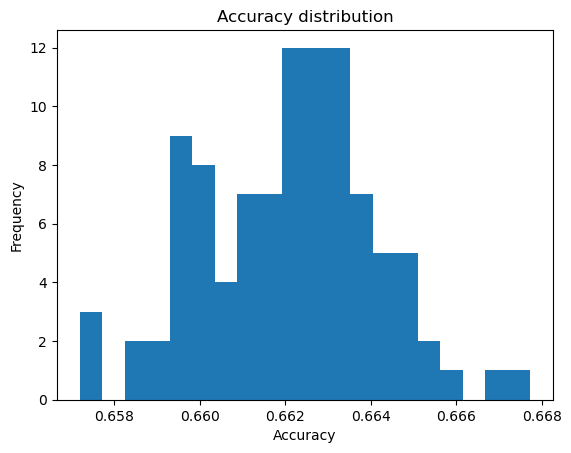

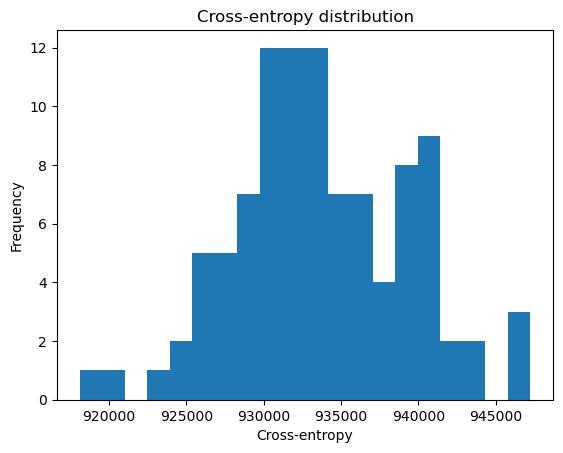

In [75]:
print("Mean accuracy: ", np.mean(accs), "+/-", np.std(accs), "%")
print("Mean cross-entropy: ", np.mean(cens), "+/-", np.std(cens))

plt.hist(accs, bins=20)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Accuracy distribution")
plt.show()

plt.hist(cens, bins=20)
plt.xlabel("Cross-entropy")
plt.ylabel("Frequency")
plt.title("Cross-entropy distribution")
plt.show()


## Choices of optimizers and cost function

+ The cross-entropy is a natural cost function used for training a logistic regression model. Minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

+ As we saw with linear regression, we can use regularizers to modify the optimization problem.

+ Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets (recall that the test set consists of samples which the model has not been trained on). 

accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.4916, 0.4794
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.4849, 0.4682
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.7029, 0.6728
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.6785, 0.6498
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.6215, 0.6028
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.6922, 0.6625
SGD: 0.5633, 0.5617
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.6921, 0.6625
SGD: 0.5633, 0.5617
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.6918, 0.6621
SGD: 0.5633, 0.5617
finished computing 8/11 iterations
accuracy: train, test, critical
liblin: 0.6853, 0.6570
SGD: 0.5633, 0.5617
finished computing 9/11 iterations
accuracy: 

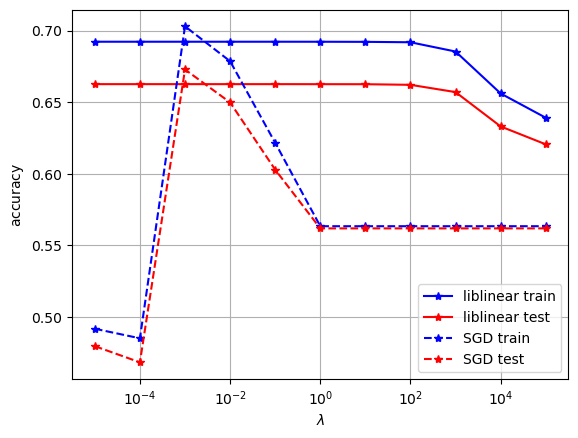

In [52]:
###### apply logistic regression
from sklearn import linear_model

# define regularisation parameter
lmbdas = np.logspace(-5, 5, 11)

# preallocate data
train_accuracy = np.zeros(lmbdas.shape, np.float64)
test_accuracy = np.zeros(lmbdas.shape, np.float64)
critical_accuracy = np.zeros(lmbdas.shape, np.float64)

train_accuracy_SGD = np.zeros(lmbdas.shape, np.float64)
test_accuracy_SGD = np.zeros(lmbdas.shape, np.float64)
critical_accuracy_SGD = np.zeros(lmbdas.shape, np.float64)

# loop over regularisation strength
for i, lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg = linear_model.LogisticRegression(
        C=1.0 / lmbda,
        random_state=1,
        verbose=0,
        max_iter=1e3,
        tol=1e-5,
        solver="liblinear",
    )

    # fit training data
    logreg.fit(X_train, y_train)

    # check accuracy
    train_accuracy[i] = logreg.score(X_train, y_train)
    test_accuracy[i] = logreg.score(X_test, y_test)
    # critical_accuracy[i] = logreg.score(X_critical, y_critical)

    print("accuracy: train, test, critical")
    print(
        "liblin: %0.4f, %0.4f"
        % (train_accuracy[i], test_accuracy[i])
    )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(
        loss="log",
        penalty="l2",
        alpha=lmbda,
        max_iter=100,
        shuffle=True,
        random_state=1,
        learning_rate="optimal",
    )

    # fit training data
    logreg_SGD.fit(X_train, y_train)

    # check accuracy
    train_accuracy_SGD[i] = logreg_SGD.score(X_train, y_train)
    test_accuracy_SGD[i] = logreg_SGD.score(X_test, y_test)
    # critical_accuracy_SGD[i] = logreg_SGD.score(X_critical, Y_critical)

    print(
        "SGD: %0.4f, %0.4f"
        % (train_accuracy_SGD[i], test_accuracy_SGD[i])
    )

    print("finished computing %i/11 iterations" % (i + 1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas, train_accuracy, "*-b", label="liblinear train")
plt.semilogx(lmbdas, test_accuracy, "*-r", label="liblinear test")
# plt.semilogx(lmbdas, critical_accuracy, "*-g", label="liblinear critical")

plt.semilogx(lmbdas, train_accuracy_SGD, "*--b", label="SGD train")
plt.semilogx(lmbdas, test_accuracy_SGD, "*--r", label="SGD test")
# plt.semilogx(lmbdas, critical_accuracy_SGD, "*--g", label="SGD critical")

plt.xlabel("$\\lambda$")
plt.ylabel("$\\mathrm{accuracy}$")

plt.grid()
plt.legend()


plt.show()


## Interpreting the results

+ From the figure above, we can read off the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

